# Classification Models

## Import packages

In [25]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, roc_auc_score, roc_curve

In [2]:
# Progress bar attempts
from IPython.display import display
import ipywidgets as widgets
import time

progress = widgets.IntProgress(min=0, max=100)
display(progress)

for i in range(100):
    progress.value = i
    time.sleep(0.1)

IntProgress(value=0)

In [3]:
from tqdm import tqdm
import time

for i in tqdm(range(100)):
    # Simulate some work with a sleep
    time.sleep(0.1)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:10<00:00,  9.42it/s]


## Import data

In [5]:
# Import dataset
contracts = pd.read_csv('../data/contract_classification.csv')

C:\Users\franc\AppData\Local\Temp\ipykernel_988\2605769822.py:2: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  contracts = pd.read_csv('../data/contract_classification.csv')


In [8]:
# Initialize tqdm to show the progress bar
tqdm.pandas()

# Read the CSV file with progress bar
contractsRead = pd.read_csv('../data/contract_classification.csv', chunksize=1000000)

# Concatenate chunks and show progress
contracts = pd.concat([chunk for chunk in tqdm(contractsRead, total=12)], ignore_index=True)

  0%|                                                                                                            | 0/12 [00:00<?, ?it/s]C:\Users\franc\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\std.py:1181: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  for obj in iterable:
  8%|████████▎                                                                                           | 1/12 [00:05<00:57,  5.20s/it]C:\Users\franc\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\std.py:1181: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  for obj in iterable:
 17%|████████████████▋                                                                                   | 2/12 [00:10<00:51,  5.16s/it]C:\Users\franc\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\std.py:1181: DtypeWarning: Columns (9) have mixed types. Specify dtype option on impor

In [10]:
# Clean data that is not needed for the model
contracts = contracts.drop(['SF-SYSTEM', 'ANO_SID', 'ORTS-NAME', 'STRASSE', 'PARTY-ID', 'contract_year'], axis=1)
contracts = contracts.dropna()

## K-nearest neighbours

### Preparation

In [11]:
# Training data: 2014; testing data: 2015
train = contracts[contracts['YEAR']==2014]
test = contracts[contracts['YEAR']==2015]

# Separate features and target variable
X_train = train.drop(['YEAR', 'DAMAGE'], axis=1)
y_train = train['DAMAGE']

X_test = test.drop(['YEAR', 'DAMAGE'], axis=1)
y_test = test['DAMAGE']

In [12]:
# Random undersampling
rus = RandomUnderSampler(random_state=1234)
X_rus, y_rus = rus.fit_resample(X_train, y_train)

print('Resampled dataset shape:', X_rus.shape, y_rus.shape)

Resampled dataset shape: (19636, 14) (19636,)


In [13]:
# Identify numerical and categorical columns
numerical = X_rus.select_dtypes(include=['int64', 'float64']).columns
categorical = X_rus.select_dtypes(include=['object']).columns

# Ensure categorical features are strings
X_rus[categorical] = X_rus[categorical].astype(str)

In [14]:
# Create the preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical)
    ])

# Create the pipeline with the preprocessor and the model
KNNmodel = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', KNeighborsClassifier(n_neighbors=13))
])

### Hyperparameter tuning

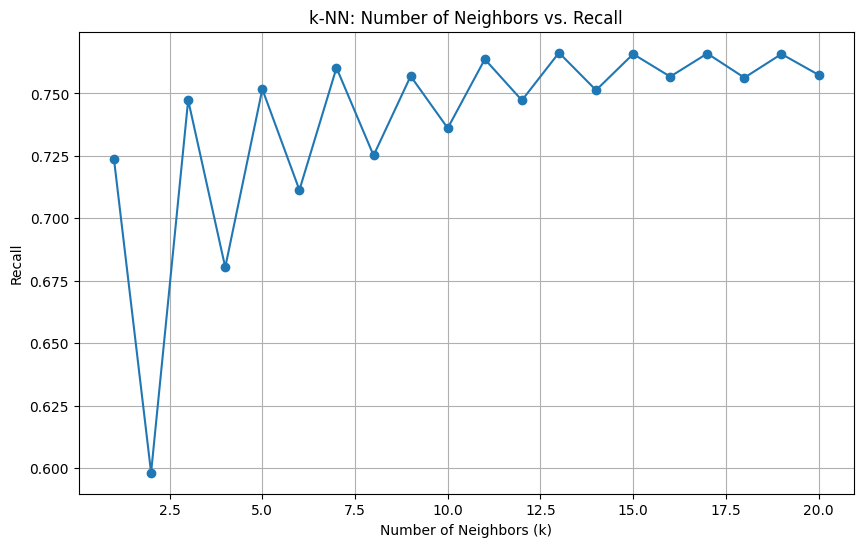

In [8]:
# Initialize lists to store recall scores for different k
k_values = range(1, 21)
recall_scores = []

# Loop over different values of k
for k in k_values:
    # Create the pipeline with the preprocessor and the KNN model
    model = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', KNeighborsClassifier(n_neighbors=k))
    ])
    
    # Train the model with resampled training data
    model.fit(X_rus, y_rus)
    
    # Predict on the test set
    y_pred = model.predict(X_test)
    
    # Calculate recall
    recall = recall_score(y_test, y_pred, average='binary')
    recall_scores.append(recall)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(k_values, recall_scores, marker='o')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Recall')
plt.title('k-NN: Number of Neighbors vs. Recall')
plt.grid()
plt.show()

AUC tuning: 100%|███████████████████████████████████████████████████████████████████████████████████████| 20/20 [21:30<00:00, 64.54s/it]


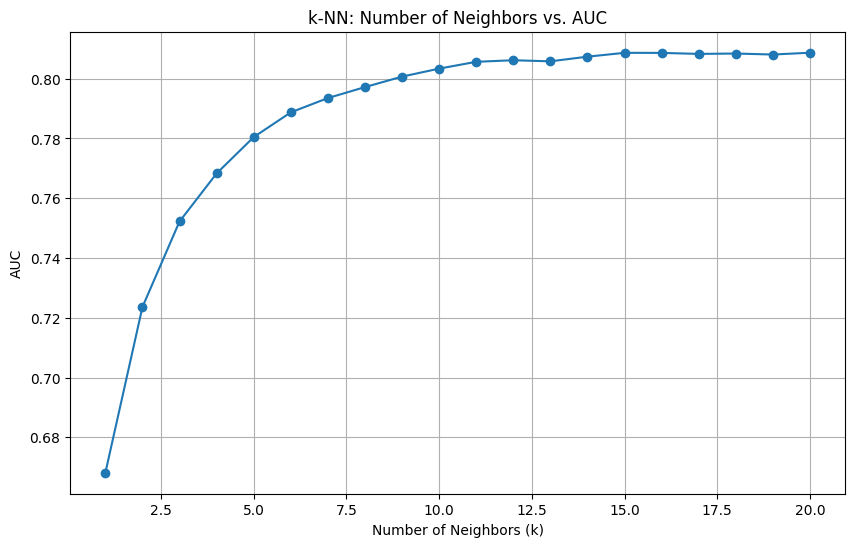

In [45]:
# Initialize lists to store AUC scores for different k
k_values = range(1, 21)
auc_scores = []

# Loop over different values of k
for k in tqdm(k_values, desc="AUC tuning"):
    # Create the pipeline with the preprocessor and the KNN model
    model = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', KNeighborsClassifier(n_neighbors=k))
    ])
    
    # Train the model with resampled training data
    model.fit(X_rus, y_rus)
    
    # Predict on the test set
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # Calculate AUC
    auc = roc_auc_score(y_test, y_pred_proba)
    auc_scores.append(auc)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(k_values, auc_scores, marker='o')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('AUC')
plt.title('k-NN: Number of Neighbors vs. AUC')
plt.grid()
plt.show()

### Model and evaluation

We are interested in the recall. We want to reduce the false negative, as these are contracts predicted as non-risky, which in reality present a risk.

Recall is the ratio of correctly predicted positive observations to the all observations in actual class.

High recall means that most of the actual positive cases are captured by the model, even if it means including some false positives.

Recall = TP / (TP + FN)

In [15]:
# Create the preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical)
    ])

# Create the pipeline with the preprocessor and the model
KNNmodel = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', KNeighborsClassifier(n_neighbors=13))
])

In [16]:
# Train the model
KNNmodel.fit(X_rus, y_rus)

# Predict on the test set
y_pred = KNNmodel.predict(X_test) # binary prediction
y_pred_proba = KNNmodel.predict_proba(X_test)[:, 1] # probability prediction

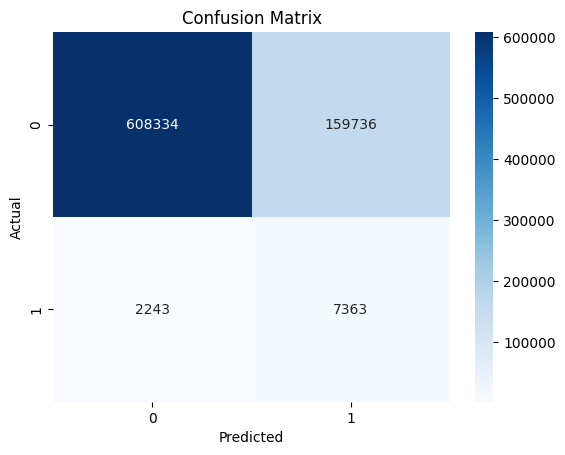

In [17]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [18]:
# Recall score
recall_score(y_test, y_pred, average='binary')

0.7665001041016032

In [24]:
# Compute AUC
auc = roc_auc_score(y_test, y_pred_proba)
print(f"AUC: {auc}")

AUC: 0.8243610859828497


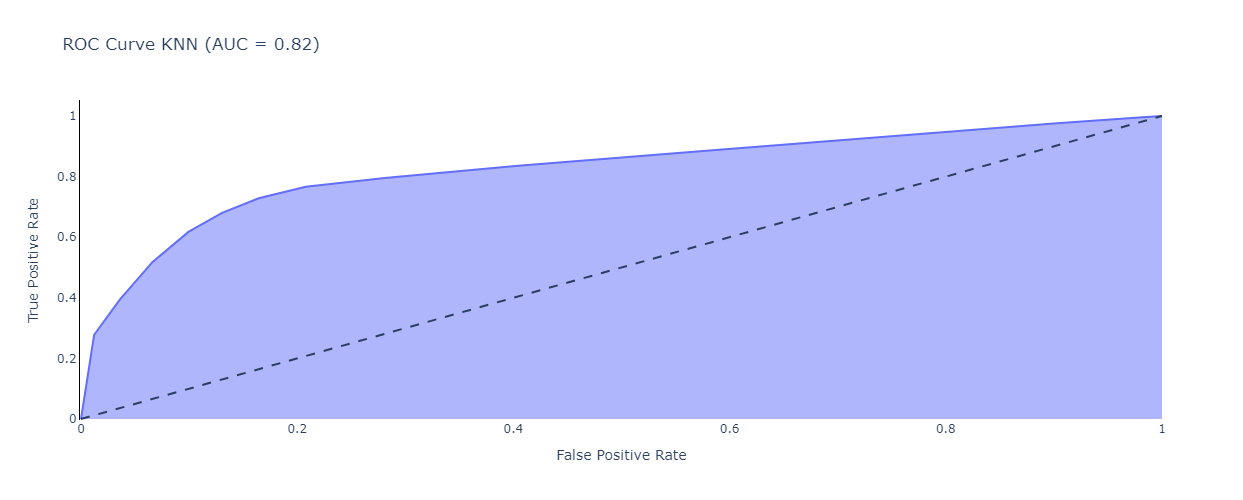

In [31]:
# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Create a DataFrame for Plotly
roc_data = pd.DataFrame({
    'False Positive Rate': fpr,
    'True Positive Rate': tpr
})

# Plot ROC curve
fig = px.area(
    roc_data, 
    x='False Positive Rate', 
    y='True Positive Rate', 
    title=f'ROC Curve KNN (AUC = {auc:.2f})',
    width=700, 
    height=500
)

fig.update_layout(
    plot_bgcolor='white',
    xaxis=dict(showgrid=False),
    yaxis=dict(showgrid=False, linecolor='black'),
    paper_bgcolor='white'
)

fig.add_shape(
    type='line',
    line=dict(dash='dash'),
    x0=0, x1=1, y0=0, y1=1
)

fig.show()

## KNN on 10 years

In [32]:
results = []
rus = RandomUnderSampler(random_state=1234)

for year in tqdm(range(2014, 2024), desc="Processing years"):
    train = contracts[contracts['YEAR'] == year]
    test = contracts[contracts['YEAR'] == year + 1]

    X_train = train.drop(['YEAR', 'DAMAGE'], axis=1)
    y_train = train['DAMAGE']
    X_test = test.drop(['YEAR', 'DAMAGE'], axis=1)
    y_test = test['DAMAGE']

    X_rus, y_rus = rus.fit_resample(X_train, y_train)

    numerical = X_rus.select_dtypes(include=['int64', 'float64']).columns
    categorical = X_rus.select_dtypes(include=['object']).columns
    X_rus[categorical] = X_rus[categorical].astype(str)

    preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical)
    ])

    KNNmodel = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', KNeighborsClassifier(n_neighbors=13))
    ])

    KNNmodel.fit(X_rus, y_rus)
#    y_pred = KNNmodel.predict(X_test)
    y_pred_proba = KNNmodel.predict_proba(X_test)[:, 1]

    auc = roc_auc_score(y_test, y_pred_proba)
#    recall = recall_score(y_test, y_pred, average='binary')
    results.append({'year': year, 'auc': auc})

results_df = pd.DataFrame(results)

Processing years: 100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [09:59<00:00, 59.98s/it]


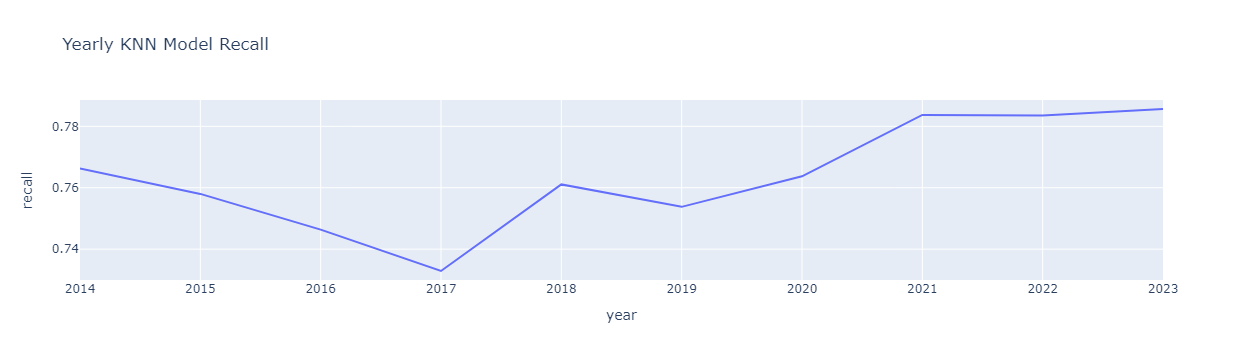

In [23]:
# Plotting the results
fig = px.line(results_df, x='year', y='recall', title='Yearly KNN Model Recall')
fig.show()

In [24]:
results_df['recall'].mean()

0.7634987045090389

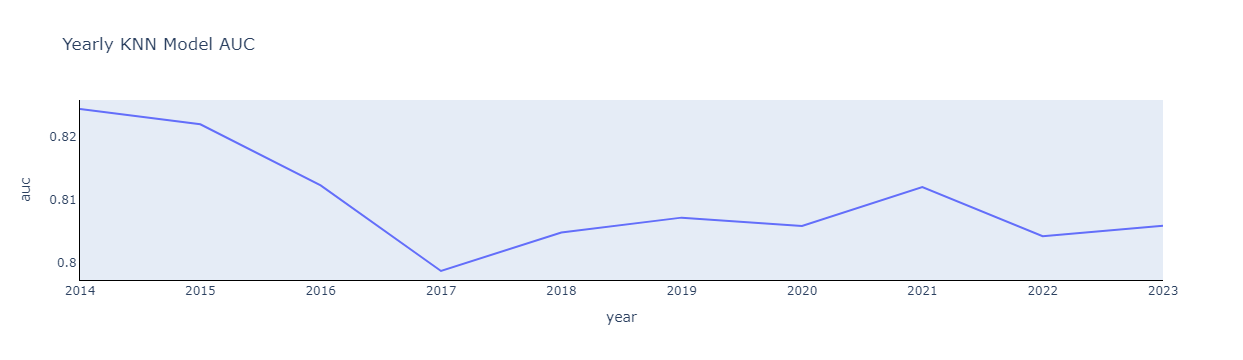

In [41]:
# Plotting the results
fig = px.line(results_df, x='year', y='auc', title='Yearly KNN Model AUC')

fig.update_layout(
    xaxis=dict(showgrid=False, linecolor='black'),
    yaxis=dict(showgrid=False, linecolor='black'),
    paper_bgcolor='white'
)

fig.show()

In [42]:
results_df['auc'].mean()

0.8096841553043198

## Support Vector Machines